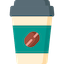

# Text Classification with NNLM

We use a pre-trained variation of Google's Neural Net Language Models (NNLM) - a token-based text embedding trained model that can map any body of text into 128 dimensional embeddings.

We explore NNLM in this notebook to better understand how it compares to BERT.

##### View this notebook in [Google Colab](https://drive.google.com/file/d/1wAEuXVQxNqMikAbY69_RisjRB-876YV-/view?usp=sharing)

# Import Resources

Mount Google Drive and import required libaries - including `pandas` and `BeautifulSoup`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
import sklearn
import numpy as np
import os
import shutil

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text
!pip install -q tf-models-official

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from matplotlib import pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 3.4MB 8.2MB/s 
     |████████████████████████████████| 1.1MB 7.6MB/s 
     |████████████████████████████████| 37.6MB 71kB/s 
     |████████████████████████████████| 1.2MB 56.2MB/s 
     |████████████████████████████████| 358kB 41.9MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 102kB 13.2MB/s 
     |████████████████████████████████| 174kB 56.8MB/s 
     |████████████████████████████████| 706kB 52.6MB/s 
     |████████████████████████████████| 645kB 56.5MB/s 


# Import and Preprocess Training Data

We first import our training data that was generated with our web scraping script. After the data is imported into this environment, we preprocess the records to get them ready for training and testing.

### Data Import

We use `pandas` to simply read in our data from Google Drive.

In [ ]:
import tensorflow as tf
import pandas as pd

csv_file=tf.keras.utils.get_file(fname="/content/drive/MyDrive/coffee data/all_review_data.csv",origin="/content/drive/MyDrive/coffee data/all_review_data.csv")

df=pd.read_csv(csv_file)


## Data Preprocessing

### Generating Our Target Variable

Our neural network will use a set of embeddings from tasting descriptions to predict what class of roast a particular coffee would likely fall into.We derive our target variable from the Agtron score - a value ranging from 25-80 that denotes the color of a coffee bean.

For more information about Agtron scores, visit [CoffeeReview](https://www.coffeereview.com/coffee-reference/coffee-categories/roast-styles/roast-table/) 
or reference the tables below.


| Roast color | Bean surface | Agtron Numbers | Common names |
|:-:|:-:|:-:|:-:|
| Light brown | Dry | 80 – 70 | Light Cinnamon New England |
| Medium brown | Dry | 70 – 50 | Medium American Regular City Brown |
| Medium-dark brown | Dry to tiny droplets or patches of oil | 50 – 40 | Viennese Full-city Light French Espresso Light espresso Continental After-dinner European |
| Dark brown | Shiny surface | 40-35 | French Espresso Italian Turkish Dark |
| Very dark brown | Very shiny surface | 35-30 | Italian Dark French Neapolitan Spanish Heavy |
| Black-brown | Shiny surface | 30-25 | Dark French Neapolitan Spanish |

| Agtron Numbers | Notes |
|:-:|:-:|
| 80 – 70 | Can taste sour and grainy. Typically used only for inexpensive commercial blends. |
| 70 – 50 | The traditional American norm. Flavor is fully developed; acidity is bright; characteristics of green coffee are clear. |
| 50 – 40 | The normal or regular roast for the West and for many newer specialty roasters. Acidity and the characteristics of the green coffee begin to mute. Bittersweetness emerges. The norm for northern-Italian style espresso. |
| 40-35 | The normal or regular roast for many roasters in the West and Southwest. Acidity is nearly gone; the characteristics of the green coffee muted. Bittersweet tones dominate. The norm for most American-style espresso. |
| 35-30 | The normal or regular roast for Peet’s Coffee and its imitators. Acidity is gone. In tactful versions of this roast some characteristics of the green coffee survive; in aggressive versions all coffees taste the same: bittersweet with hints of burned or charred tones. |
| 30-25 | All differentiating characteristics of the green coffee are gone; burned or charred notes dominate. Body is thin. Flavor is reduced to faint sweet tones. |

In [ ]:
# Split Agtron Score - 
df[['Agrtron_Bean','Agtron_Ground']] = df.Agtron.str.split('/',expand=True) 

# Remove Null Values
df=df[~df['Agrtron_Bean'].isnull()]
df=df[df['Agrtron_Bean']!='NA']
df=df[df['Agrtron_Bean']!='']

# Replace Likely Fat Fingered Scores
df['Agrtron_Bean']=df['Agrtron_Bean'].replace('547','54')
df['Agrtron_Bean']=df['Agrtron_Bean'].replace('555','55')

# Push Target Variable to Float
df['Agrtron_Bean']=df['Agrtron_Bean'].astype(float)

# Bucketize Target Variable into 6 Classess
df['class'] = pd.cut(df['Agrtron_Bean'], [25,30,35,40,50,70,80], labels=['BlackBrown','VeryDarkBrown','DarkBrown','MediumDarkBrown','MediumBrown','LightBrown'])

# Remove Records with No Class
df=df[~df['class'].isna()]

In [ ]:
# Preview of Our Data

print ("Here is our raw data:")
df.head(5)

Here is our raw data:


,Unnamed: 0,score,roaster,title,Roaster Location,Coffee Origin,Roast Level,Agtron,Est. Price,blind_assessment,notes,bottom_line,Agrtron_Bean,Agtron_Ground,class
0,0,95,Temple Coffee Roasters,Kenya Gachatha,"Sacramento, California",South-central Kenya,Medium-Light,54/72,$22.50/12 ounces,"Sweetly spice-toned, chocolaty. Star jasmine, ...","<span style=""font-weight: 400;"">Despite grower...","Richly spice-toned, floral- and fruit-driven, ...",54.0,72,MediumBrown
1,1,94,Temple Coffee Roasters,Ethiopia Suke Quto Single-Origin Espresso,"Sacramento, California","Guji Zone, Oromia Region, south-central Ethiopia",Medium-Light,52/72,$19.00/12 ounces,"Evaluated as espresso. Richly fruit-centered, ...","<span style=""font-weight: 400;"">Produced by Te...","An impressive, affordably priced single-origin...",52.0,72,MediumBrown
2,2,94,Temple Coffee Roasters,Ethiopia Gera Limu,"Sacramento, California","Oromia growing region, southern Ethiopia",Medium-Light,58/80,$19.00/12 ounces,"Delicately sweet, subtly tart, elegant. Aprico...","<span style=""font-weight: 400;"">Produced by Ak...","A balanced, juicy washed Ethiopia cup driven b...",58.0,80,MediumBrown
3,3,93,Temple Coffee Roasters,Peru Tambopata,"Sacramento, California","Puno, Sandia Valley, Peru",Medium,52/68,$19.00/12 ounces,"Floral-toned, richly chocolaty. Lilac, toffee,...","<span style=""font-weight: 400;"">Produced by sm...",A resonant Peru cup with notes of deep florals...,52.0,68,MediumBrown
4,4,94,Prairie Lily Coffee,Panama Pacamara Natural,"Lloydminster, Saskatchewan, Canada","Volcan growing region, western Panama",Medium-Light,52/70,CAD $50/200 grams,"Rich-toned, chocolaty, fruit-centered. Chocola...","<span style=""font-weight: 400;"">Produced at th...","A deep, brooding, balanced Panama Pacamara cup...",52.0,70,MediumBrown


### Generate Our Feature Variable

Our neural network will use a set of embeddings from tasting descriptions to predict what class of roast a particular coffee would likely fall into. Our feature column is a concatenation of three free-text fields that are typical for a coffee review - blind assessment, tasting notes, and bottom line.

The code below prepeares our feature column for Tensorflow. We concatenate our
text fields, remove HTML tags, strip stopwords, and downsize our dataframe to our two columns of interest - target and feature.


In [ ]:
# Generate our feature column - combining three text fields into a single string per review/record.
df['bottom_line']=df['bottom_line'].fillna('')
df['notes']=df['notes'].fillna('')
df['blind_assessment']=df['blind_assessment'].fillna('')

df['text']=df['bottom_line']+' '+df['notes']+' '+df['blind_assessment']

# Define Our Stopwords with NLTK
# Our word embedding layer likely removes stopwords, but we remove them in our preprocessing stage for peace of mind.
stop = stopwords.words('english')

df['text']= df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Remove HTML tags from our free-text field
def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result

df['text']=df['text'].apply(lambda cw : remove_tags(cw))

# Subset our dataframe to our two columns of interest

df=df[['class','text']]

In [ ]:
# Preview of Our Data

print ("Here is our data after some initial preprocessing:")
df.head(5)

Here is our data after some initial preprocessing:


,class,text
0,MediumBrown,"Richly spice-toned, floral- fruit-driven, comp..."
1,MediumBrown,"An impressive, affordably priced single-origin..."
2,MediumBrown,"A balanced, juicy washed Ethiopia cup driven n..."
3,MediumBrown,"A resonant Peru cup notes deep florals, stone ..."
4,MediumBrown,"A deep, brooding, balanced Panama Pacamara cup..."


### Encode our Target Variable

Tensorflow operates under the assumption that it's inputs,intermediary layers, and outputs are all tensors or vectors with some arbitrary dimension.

We use `sklearn.preprocessing.LabelEncoder` to encoder our target labels with value between 0 and n_classes-1.


In [ ]:
# Encoding
encoder = LabelEncoder()
df['class2'] = encoder.fit_transform(df['class'])

# Store Our Class Mappings for Reference Later
class_mapping=df[['class','class2']]

# Subset our dataframe to our two columns of interest
df=df[['text','class2']]

In [ ]:
# Preview of Our Data

print ("Here is our data after encoding our target value:")
df.head(5)

Here is our data after encoding our target value:


,text,class2
0,"Richly spice-toned, floral- fruit-driven, comp...",3
1,"An impressive, affordably priced single-origin...",3
2,"A balanced, juicy washed Ethiopia cup driven n...",3
3,"A resonant Peru cup notes deep florals, stone ...",3
4,"A deep, brooding, balanced Panama Pacamara cup...",3


# Model Architecture and Design

### Download and Instantiate NNLM from Tensorflow Hub


In [ ]:
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2")
embeddings = embed(["cat is on the mat", "dog is in the fog"])
print (embeddings[0])

tf.Tensor(
[ 0.27107972 -0.01055073 -0.05728397  0.06853679 -0.08438271  0.22396211
 -0.00247001 -0.09797598 -0.06092518  0.01678422  0.0183306  -0.02683547
  0.01987647  0.02205245  0.0380337   0.02345292 -0.0535214  -0.02916854
 -0.13816142  0.255649    0.00548296  0.08994407  0.09702856 -0.01617393
  0.15273312  0.03449007  0.05599031  0.01964826 -0.01901525  0.11601479
  0.06575833 -0.03560898 -0.02412845 -0.00716866 -0.08950593 -0.01021391
  0.07431487 -0.10462939 -0.03951982  0.00272066 -0.01468687 -0.01350653
 -0.04825642  0.03088917 -0.0448269  -0.01743765  0.1034883   0.04149228
 -0.03979184  0.03878277  0.15273733 -0.09228262 -0.01723959  0.01830614
 -0.02075483  0.0800882  -0.08071491 -0.15573218  0.13893387  0.06140287
 -0.05639812 -0.05526257 -0.02765993 -0.175832    0.01034007 -0.19550695
  0.06209265 -0.03193678  0.08837268 -0.05629309  0.09268684  0.05395978
 -0.01900527 -0.17626993 -0.03103094 -0.12204378 -0.00157093 -0.07853678
 -0.05892268  0.11311311  0.00749602  0.

### Model Design

We build a neural network with the Keras Layers API. Our input layer is passed thru an encoding layer that transforms our feature field into an n-dimensional space. Those encodings work thru a series of layers. The final output is a softmax layer - providing us with a probability distribution of our input layer falling into each of our six categories.


In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2",
                           input_shape=[], dtype=tf.string)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(len(np.unique(df['class2'])), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 102       
Total params: 124,644,854
Trainable params: 2,166
Non-trainable params: 124,642,688
_________________________________________________________________


### Model Compilation

We compile our model using the Adam optimizer and the Sparse Categorical Crossentropy loss function. If our target value was one-hot enoded, we could use
Categorical Crossentropy.


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Model Data

We create and execute a function to generate our training and test data.


In [ ]:
train_examples,train_labels=np.array(df['text']),np.array(df['class2'])

def train_test_split(x,y,split):

  x, y = sklearn.utils.shuffle(x, y)

  split_int=int(len(train_examples)*split)

  x_val = x[split_int:]
  partial_x_train = x[:split_int]

  y_val = y[split_int:]
  partial_y_train = y[:split_int]

  #x_val,partial_x_train= embed(x_val),embed(partial_x_train)
  return (partial_x_train,partial_y_train,x_val,y_val)

x_train,y_train,x_test,y_test=train_test_split(train_examples,train_labels,0.95)

### Model Fitting

We train the model for twenty epochs and no batch size as a proof of concept. This model beings to perform incredibly well when trained with a properly
configured batch size.

However, that process is too time-intensive for the purposes of this demo.

Feel free to play with the hyperparamters below!


In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    #batch_size=512,
                    validation_data=(x_test, y_test),
                    verbose=1)

Epoch 1/20
142/142 [==============================] - 1s 4ms/step - loss: 0.7738 - accuracy: 0.6962 - val_loss: 0.8508 - val_accuracy: 0.6569
Epoch 2/20
142/142 [==============================] - 1s 4ms/step - loss: 0.7602 - accuracy: 0.6995 - val_loss: 0.8445 - val_accuracy: 0.6569
Epoch 3/20
142/142 [==============================] - 1s 4ms/step - loss: 0.7499 - accuracy: 0.7035 - val_loss: 0.8197 - val_accuracy: 0.6862
Epoch 4/20
142/142 [==============================] - 1s 4ms/step - loss: 0.7419 - accuracy: 0.7044 - val_loss: 0.8210 - val_accuracy: 0.6736
Epoch 5/20
142/142 [==============================] - 1s 4ms/step - loss: 0.7362 - accuracy: 0.7084 - val_loss: 0.8062 - val_accuracy: 0.6736
Epoch 6/20
142/142 [==============================] - 1s 4ms/step - loss: 0.7315 - accuracy: 0.7110 - val_loss: 0.8025 - val_accuracy: 0.7071
Epoch 7/20
142/142 [==============================] - 1s 4ms/step - loss: 0.7261 - accuracy: 0.7112 - val_loss: 0.7953 - val_accuracy: 0.6611
Epoch 

### Model Review


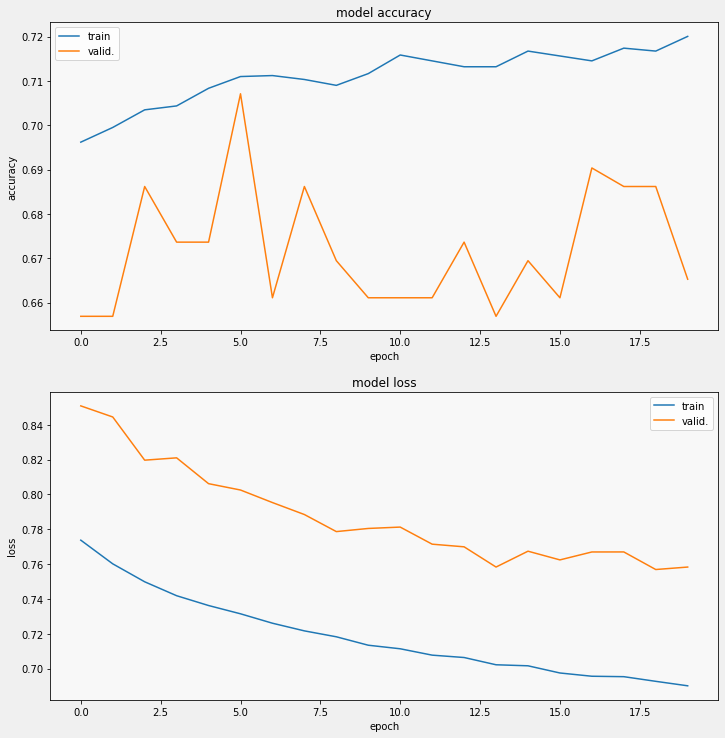

In [ ]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

### Model Evaulation


In [ ]:
results = model.evaluate(x_test,y_test)

print(results)

8/8 [==============================] - 0s 4ms/step - loss: 0.7583 - accuracy: 0.6653
[0.7583299875259399, 0.6652719378471375]


### Model Prediction


In [ ]:
my_coffee_review= '''I love a dark espresso that is rich and full bodied. Starbucks does a good espresso 
and I think that would probably be my favorite cup of coffee.'''

predictions = model(tf.constant([my_coffee_review]))
print(tf.sigmoid(predictions))

tf.Tensor([[0.5225218  0.5507067  0.5075052  0.56046563 0.5731513  0.53457737]], shape=(1, 6), dtype=float32)
